# Generating terrain using a Deep Convolutional GAN

In [1]:
from __future__ import print_function

import os
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from datetime import datetime, timedelta
from IPython.display import HTML

Set random function seeds for reproducability.

In [2]:
seed = 999

#manualSeed = random.randint(1, 10000)
random.seed(seed)
torch.manual_seed(seed)

print(seed)

999


In [3]:
data_directory = "data/Terrain/processed"
n_workers = 2

## Settings and hyperparameters

In [4]:
batch_size = 16
image_size = 512

n_channels = 1
n_latent   = 100

n_gen_features = 36
n_dis_features = 8

n_epochs    = 3000
learning_r  = 0.0002
beta1       = 0.5

g_lower_bound = 0.5
d_lower_bound = 0.5

n_gpus = 1

## Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, n_gpus):
        super(Generator, self).__init__()
        self.n_gpus = n_gpus
        self.main = nn.Sequential(
            nn.ConvTranspose2d(n_latent, n_gen_features * 64, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_gen_features * 64),
            nn.ReLU(True),

            nn.ConvTranspose2d(n_gen_features * 64, n_gen_features * 32, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_gen_features * 32),
            nn.ReLU(True),

            nn.ConvTranspose2d(n_gen_features * 32, n_gen_features * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_gen_features * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(n_gen_features * 16, n_gen_features * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_gen_features * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(n_gen_features * 8, n_gen_features * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_gen_features * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(n_gen_features * 4, n_gen_features * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_gen_features * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(n_gen_features * 2, n_gen_features, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_gen_features),
            nn.ReLU(True),

            nn.ConvTranspose2d(n_gen_features, n_channels, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, n_gpus):
        super(Discriminator, self).__init__()
        self.n_gpus = n_gpus
        self.main = nn.Sequential(
            # 256 x 256
            nn.Conv2d(n_channels, n_dis_features, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 128 x 128
            nn.Conv2d(n_dis_features, n_dis_features * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_dis_features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 x 64
            nn.Conv2d(n_dis_features * 2, n_dis_features * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_dis_features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 32 x 32
            nn.Conv2d(n_dis_features * 4, n_dis_features * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_dis_features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # 16 x 16
            nn.Conv2d(n_dis_features * 8, n_dis_features * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_dis_features * 16),
            nn.LeakyReLU(0.2, inplace=True),

            # 8 x 8
            nn.Conv2d(n_dis_features * 16, n_dis_features * 32, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_dis_features * 32),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(n_dis_features * 32, n_dis_features * 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_dis_features * 64),
            nn.LeakyReLU(0.2, inplace=True),

            # 4 x 4
            nn.Conv2d(n_dis_features * 64, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()

            # Real/fake state size 1
        )

    def forward(self, input):
        return self.main(input)

## Loading the dataset

In [7]:
dataset_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = dset.ImageFolder(root=data_directory, transform=dataset_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=n_workers)

In [8]:
run_cuda = torch.cuda.is_available() and n_gpus > 0 
device   = torch.device("cuda:0" if run_cuda else "cpu")

print(run_cuda, torch.cuda.is_available())

True True


Dataset preview

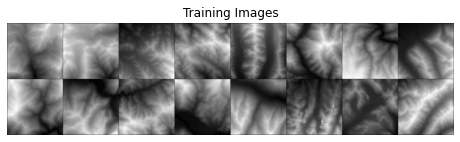

In [9]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()

Function for weight initialization

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [11]:
def save_img(image, name):
    array = array.detach()
    array = array.reshape(28,28)
    
    plt.imshow(immage, cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('output/' + name)

## Generator and discriminator definition and initialization

In [12]:
generator = Generator(n_gpus).to(device)
discriminator = Discriminator(n_gpus).to(device)

if device.type is 'cuda' and n_gpus > 1:
    generator = nn.DataParallel(n_gpus, list(range(n_gpus)))
    discriminator = nn.DataParallel(n_gpus, list(range(n_gpus)))

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.

## Loss function and optimizer initialization

In [13]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, n_latent, 1, 1, device=device)

real_label = 1
fake_label = 0

d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_r, betas=(beta1, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=learning_r, betas=(beta1, 0.999))

## Training

In [14]:
img_progress = []
gen_loss, dis_loss = [], []
iters, start_epoch = 0, 0

restore_session = True
runtime = ''

start_time = datetime.now()

In [15]:
def print_progress(line):
    with open('out.txt', 'w') as file:
        file.write(line)

### Session Management

In [16]:
def save_session(cur_epoch, cur_iters, cur_time):
    g_state = { 'state_dict': generator.state_dict(), 'optimizer': g_optimizer.state_dict() }
    d_state = { 'state_dict': discriminator.state_dict(), 'optimizer': d_optimizer.state_dict() }
    log_state = { 'iters': cur_iters, 'epoch': cur_epoch + 1, 'runtime': cur_time,
                    'img': img_progress, 'g_loss': gen_loss, 'd_loss': dis_loss }

    state = { 'g_state': g_state, 'd_state': d_state, 'log_state': log_state }
    torch.save(state, 'checkpoints/gan/latest.pth.tar')

    with torch.no_grad():
        img = generator(fixed_noise).detach().cpu()

    img_progress.append(vutils.make_grid(img, padding=2, normalize=True))
    plt.imsave('output/terrain_{}.png'.format(iters), img_progress[-1][0], cmap='Greys')

In [17]:
def load_session(filename='checkpoints/gan/latest.pth.tar'):
    if os.path.isfile(filename):
        print('=> Loading checkpoint from {}'.format(filename))
        checkpoint = torch.load(filename)
        return checkpoint
    else:
        print('=> Checkpoint {} not found'.format(filename))

In [18]:
if os.path.isfile('checkpoints/gan/latest.pth.tar') and restore_session:
    session = load_session('checkpoints/gan/latest.pth.tar')

    # Load logs
    img_progress = session['log_state']['img']
    gen_loss, dis_loss = session['log_state']['g_loss'], session['log_state']['d_loss']
    iters, start_epoch = session['log_state']['iters'], session['log_state']['epoch']
    runtime = session['log_state']['runtime']

    # Load generator
    generator.load_state_dict(session['g_state']['state_dict'])
    g_optimizer.load_state_dict(session['g_state']['optimizer'])

    # Load discriminator
    discriminator.load_state_dict(session['d_state']['state_dict'])
    d_optimizer.load_state_dict(session['d_state']['optimizer'])

    dt = datetime.strptime(runtime, '%H:%M:%S')
    runtime_delta = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    start_time = start_time - runtime_delta

=> Loading checkpoint from checkpoints/latest.pth.tar


### Training Loop

In [19]:
# Start training
for epoch in range(start_epoch, n_epochs):
    for i, data in enumerate(dataloader):
        discriminator.zero_grad()
        generator.zero_grad()

        b_size = data[0].size(0)

        # Fill labels
        r_label = torch.full((b_size,), 1, device=device)
        f_label = torch.full((b_size,), 0, device=device)

        # Generate batch of fake images
        g_noise = torch.randn(b_size, n_latent, 1, 1, device=device)
        g_output = generator(g_noise)

        # Train D with real batch
        # label.fill_(real_label)
        d_output = discriminator(data[0].to(device)).view(-1)
        d_error_r = criterion(d_output, r_label)
        d_error_r.backward(retain_graph=True)

        # Fake D with fake batch
        d_output = discriminator(g_output.detach()).view(-1)
        d_error_f = criterion(d_output, f_label)
        d_error_f.backward(retain_graph=True)

        d_error = d_error_r + d_error_f
        
        # Step discriminator
        if d_error.item() > d_lower_bound:
            d_optimizer.step()

        # Train generator
        d_output = discriminator(g_output).view(-1)
        g_error = criterion(d_output, r_label)
        g_error.backward(retain_graph=True)

        # Step generator
        g_optimizer.step()

        runtime = str(datetime.now() - start_time).split('.')[:1][0]

        if i % 5 is 0:
            print_progress('Runtime: \e[32m%s\e[0m\n\n[\e[32m%d\e[0m/\e[32m%d\e[0m] [\e[32m%d\e[0m/\e[32m%d\e[0m] [\e[32m%d\e[0m] d_loss: \e[32m%.4f\e[0m g_loss: \e[32m%.4f\e[0m CUDA: \e[32m%s\e[0m' %
                (runtime, epoch + 1, n_epochs, i, len(dataloader), iters, d_error.item(), g_error.item(), run_cuda))
        
        gen_loss.append(g_error.item())
        dis_loss.append(d_error.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 1000 is 0 and i is not 0) or (epoch is n_epochs - 1 and i == len(dataloader) - 1):
            save_session(epoch, iters, runtime)

        iters += 1

KeyboardInterrupt: 

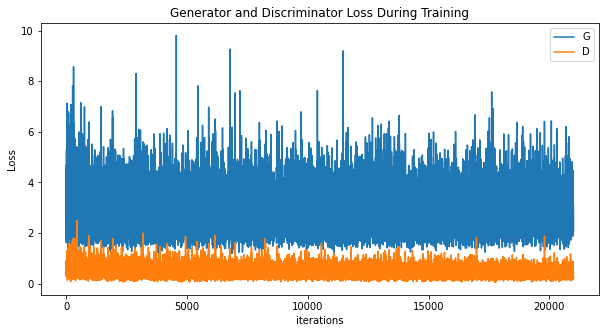

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_loss,label="G")
plt.plot(dis_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

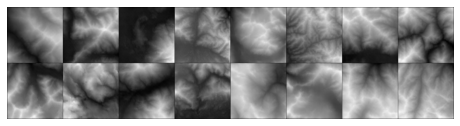

In [20]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
images = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_progress]
anim = animation.ArtistAnimation(fig, images, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

# Generate!

512


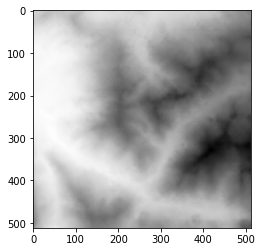

In [54]:
latent = torch.randn(1, n_latent, 1, 1, device=device)

with torch.no_grad():
    fake = generator(latent).cpu()

plt.imshow(vutils.make_grid(fake, padding=2, normalize=True)[0], cmap='Greys')
plt.imsave('generated.png', fake[0][0], cmap='Greys')